# Computational Drug Design - Final Project

Author: Vojtech Melichar
Year: AY 2022/23

## Import of dataset

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gzip
from itertools import chain

from rdkit import Chem
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors

from rdkit import RDLogger

RDLogger.DisableLog('rdApp.error')

from sklearn.model_selection import train_test_split

## Standardization of molecules

In [4]:
""" contribution from Hans de Winter """
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None
def NeutraliseCharges(mol, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = Chem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    return mol, replaced

In [5]:
_saltRemover = SaltRemover()
_inorganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]") # to remove compounds with unwanted atom types
_carbonPatt = Chem.MolFromSmarts("[#6]") # to remove compounds without carbon - inorganic

def standardize(mol):
    if mol.HasSubstructMatch(_carbonPatt):
        mol = _saltRemover(mol)
        if mol.GetNumAtoms()==0:
            return None
        else:
            mol, neutralized = NeutraliseCharges(mol)
            if mol.HasSubstructMatch(_inorganicPatt):
                return None
            else:
                # Sanitize mol, without sanitization some structures can't be drawn or fingerprinted
                Chem.SanitizeMol(mol) # add catch block?
                return mol
    else:
        return None

## Lipinski's Rule of Five

In [6]:
# do lipinski's rule of five filtering
def lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    if mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10:
        return True
    else:
        return False

## PAINs filter

In [7]:
# load PAINS structures in SMARTS format from two files in data
pains = []
with open('../data/pains/p_l15.txt', 'r') as f, open('../data/pains/p_m150.txt', 'r') as p:
    for line in chain(f, p):
        pattern, text = line.strip().split('\t') # split by tab
        pains.append(Chem.MolFromSmarts(pattern)) # remove the xml tags
len(pains)

425

In [8]:
def gen_pains(mol, keys=pains):
    structure_key = [mol.HasSubstructMatch(pain) for pain in pains]
    return sum(structure_key)

## Predicting active/decoys molecules on DUDE dataset

In [9]:
with gzip.open('actives_final.sdf.gz') as sdf:
    supp_actives = Chem.ForwardSDMolSupplier(sdf)
    actives = [[mol, 'actives'] for mol in supp_actives if mol]

with gzip.open('decoys_final.sdf.gz') as sdf:
    supp_decoys = Chem.ForwardSDMolSupplier(sdf)
    decoys = [[mol, 'decoys'] for mol in supp_decoys if mol]

df_ac = pd.DataFrame(actives, columns=['Mol', 'Source'])
df_de = pd.DataFrame(decoys, columns=['Mol', 'Source'])

df_c = pd.concat((df_ac, df_de), ignore_index=True)
df_c

,Mol,Source
0,<rdkit.Chem.rdchem.Mol object at 0x7f455f5df940>,actives
1,<rdkit.Chem.rdchem.Mol object at 0x7f455f5622b0>,actives
2,<rdkit.Chem.rdchem.Mol object at 0x7f455f561170>,actives
3,<rdkit.Chem.rdchem.Mol object at 0x7f455f561260>,actives
4,<rdkit.Chem.rdchem.Mol object at 0x7f455f562210>,actives
...,...,...
29121,<rdkit.Chem.rdchem.Mol object at 0x7f455f067350>,decoys
29122,<rdkit.Chem.rdchem.Mol object at 0x7f455f0673f0>,decoys
29123,<rdkit.Chem.rdchem.Mol object at 0x7f455f067490>,decoys
29124,<rdkit.Chem.rdchem.Mol object at 0x7f455f067530>,decoys


In [10]:
df_c['Mol'] = df_c['Mol'].apply(standardize)
print(f'{df_c["Mol"].isna().sum()} molecules could not be standardized')
df_c.dropna(inplace=True)

104 molecules could not be standardized


In [11]:
df_c['lip5'] = df_c['Mol'].apply(lipinski)
print(f'{df_c["lip5"].sum()} molecules pass Lipinski\'s rule of five')
print(f'{df_c.shape[0] - df_c["lip5"].sum()} molecules do not pass Lipinski\'s rule of five')

26405 molecules pass Lipinski's rule of five
2617 molecules do not pass Lipinski's rule of five


In [12]:
df_c['pains'] = df_c['Mol'].apply(gen_pains)
print(f"{df_c[df_c['pains'] > 0].pains.shape[0]} molecules contain PAINS substructures")
print(df_c.pains.value_counts())
df_c = df_c[df_c['pains'] == 0]

418 molecules contain PAINS substructures
0    28604
1      417
2        1
Name: pains, dtype: int64


In [13]:
fp_df_c = pd.DataFrame((list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in df_c["Mol"]), columns=[*(f"FP_{x}" for x in range(1,1025))])
fp_df_c = fp_df_c.join(df_c["Source"])
print(fp_df_c.shape)

fp_df_c.replace([np.inf, -np.inf], np.nan, inplace=True)
fp_df_c.dropna(inplace=True)
print(fp_df_c.shape)
fp_df_c['Source'] = fp_df_c['Source'].apply(lambda x: True if x == 'actives' else False)
fp_df_c

(28604, 1025)
(28093, 1025)


,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,...,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,FP_1024,Source
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,True
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,True
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,True
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28599,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28600,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28601,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False
28602,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,False


In [14]:
# train test split
X = fp_df_c.drop("Source", axis=1)
y = fp_df_c["Source"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((17979, 1024), (17979,), (5619, 1024), (5619,), (4495, 1024), (4495,))

### Random Forest Classifier

In [15]:
# do random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_pred_proba_rf)
threshold = thresholds[np.argmax((2 * precision * recall) / (precision + recall))]
print(f"Best threshold (best F1 score): {threshold}")

Best threshold (best F1 score): 0.13


Accuracy: 1.0
Precision: 0.96
Recall: 0.91
F1: 0.94
ROC AUC: 0.96


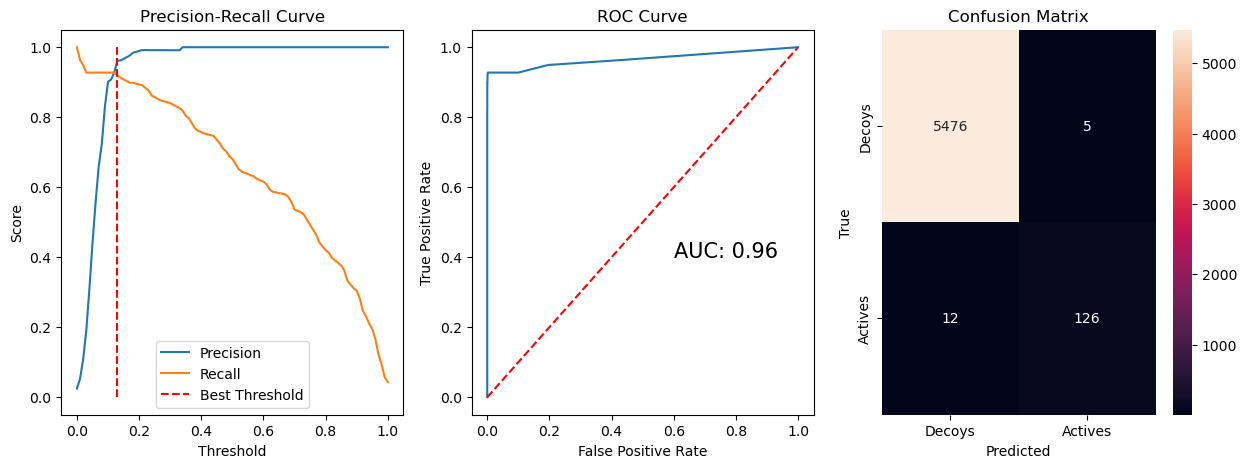

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(thresholds, precision[:-1], label="Precision")
ax1.plot(thresholds, recall[:-1], label="Recall")
ax1.vlines(threshold, 0, 1, linestyles='--', color='red', label="Best Threshold")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Precision-Recall Curve")
ax1.legend()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test.astype(int), y_pred_proba_rf)

ax2.plot(fpr, tpr)
ax2.plot([0,1], [0,1], linestyle='--', color='red')
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
# auc score in plot
y_pred_rf = y_pred_proba_rf > threshold
ax2.text(0.6, 0.4, f"AUC: {roc_auc_score(y_test, y_pred_rf).round(2)}", fontsize=15)

# print metrics for best threshold
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf).round(2)}")
print(f"Precision: {precision_score(y_test, y_pred_rf).round(2)}")
print(f"Recall: {recall_score(y_test, y_pred_rf).round(2)}")
print(f"F1: {f1_score(y_test, y_pred_rf).round(2)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_rf).round(2)}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm, annot=True, fmt='g')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
ax3.set_title("Confusion Matrix")
ax3.xaxis.set_ticklabels(['Decoys', 'Actives'])
ax3.yaxis.set_ticklabels(['Decoys', 'Actives'])
plt.show()

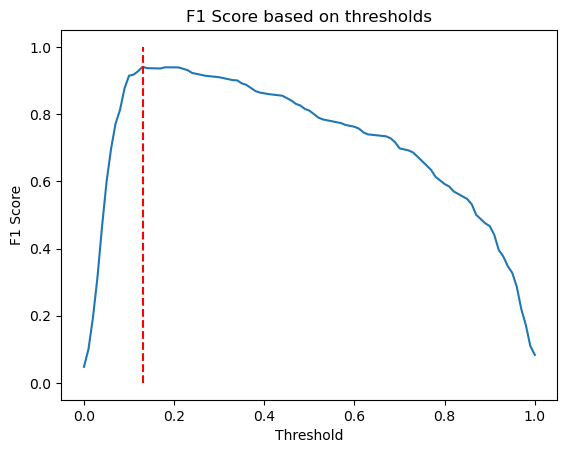

In [17]:
plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1]))
plt.vlines(threshold, 0, 1, linestyles='--', color='red', label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score based on thresholds")
plt.show()

### LightGBM Classifier

In [18]:
# do lgbm classification
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'cross_entropy',
    'verbose': -1
}

gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# find best threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
threshold = thresholds[np.argmax((2 * precision * recall) / (precision + recall))]
print(f"Best threshold (best F1 score): {threshold}")

Best threshold (best F1 score): 0.12338377143630216


In [19]:
# # do bayesian optimization
# from bayes_opt import BayesianOptimization

# def lgb_eval_function(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
#     params = {
#         'objective': 'binary',
#         'metric': 'cross_entropy',
#         'verbose': -1,
#         'num_leaves': int(num_leaves),
#         'feature_fraction': max(min(feature_fraction, 1), 0),
#         'bagging_fraction': max(min(bagging_fraction, 1), 0),
#         'max_depth': int(max_depth),
#         'lambda_l1': max(lambda_l1, 0),
#         'lambda_l2': max(lambda_l2, 0),
#         'min_split_gain': min_split_gain,
#         'min_child_weight': min_child_weight
#     }

#     cv_result = lgb.cv(params, lgb_train, num_boost_round=100, nfold=5, stratified=True, shuffle=True, metrics='auc', early_stopping_rounds=10, verbose_eval=False, seed=42)

#     return max(cv_result['auc-mean'])

# lgbBO = BayesianOptimization(lgb_eval_function, {'num_leaves': (24, 45),
#                                         'feature_fraction': (0.1, 0.9),
#                                         'bagging_fraction': (0.8, 1),
#                                         'max_depth': (5, 8.99),
#                                         'lambda_l1': (0, 5),
#                                         'lambda_l2': (0, 3),
#                                         'min_split_gain': (0.001, 0.1),
#                                         'min_child_weight': (5, 50)}, random_state=42)

# lgbBO.maximize(init_points=5, n_iter=25)

# # get best parameters
# params = lgbBO.max['params']
# params['num_leaves'] = int(params['num_leaves'])
# params['max_depth'] = int(params['max_depth'])

# # train model with best parameters
# gbm = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=False)

# y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# # find best threshold
# precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# threshold = thresholds[np.argmax((2 * precision * recall) / (precision + recall))]
# print(f"Best threshold (best F1 score): {threshold}")

Accuracy: 1.0
Precision: 0.96
Recall: 0.9
F1: 0.93
ROC AUC: 0.95


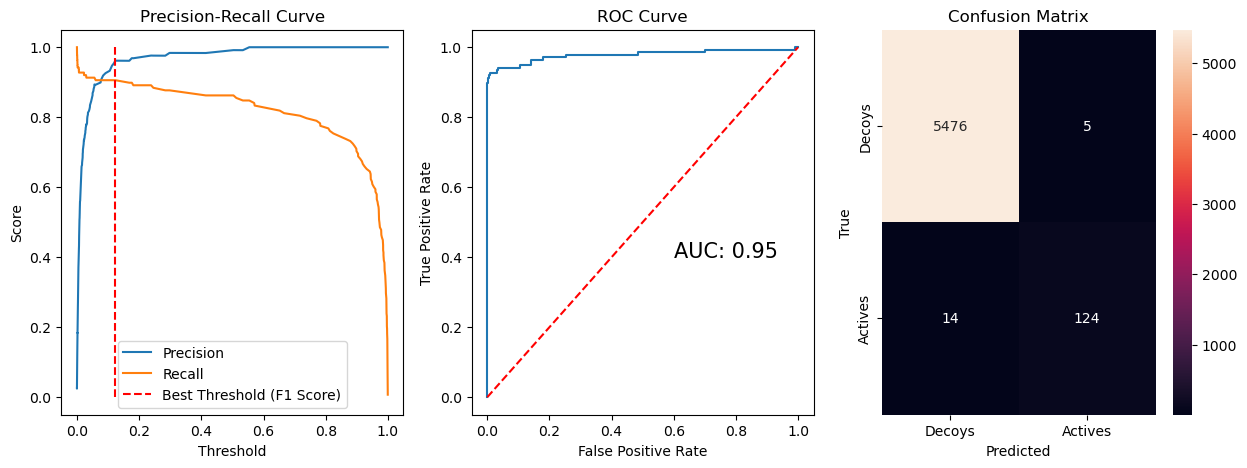

In [20]:
# plot subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(thresholds, precision[:-1], label="Precision")
ax1.plot(thresholds, recall[:-1], label="Recall")
ax1.vlines(threshold, 0, 1, linestyles='--', color='red', label="Best Threshold (F1 Score)")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Score")
ax1.set_title("Precision-Recall Curve")
ax1.legend()

# plot roc curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

ax2.plot(fpr, tpr)
ax2.plot([0,1], [0,1], linestyle='--', color='red')
ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("ROC Curve")
# auc score in plot
y_pred = y_pred > threshold
ax2.text(0.6, 0.4, f"AUC: {roc_auc_score(y_test, y_pred).round(2)}", fontsize=15)

# print metrics for best threshold
print(f"Accuracy: {accuracy_score(y_test, y_pred).round(2)}")
print(f"Precision: {precision_score(y_test, y_pred).round(2)}")
print(f"Recall: {recall_score(y_test, y_pred).round(2)}")
print(f"F1: {f1_score(y_test, y_pred).round(2)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred).round(2)}")

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='g')
ax3.set_xlabel("Predicted")
ax3.set_ylabel("True")
ax3.set_title("Confusion Matrix")
ax3.xaxis.set_ticklabels(['Decoys', 'Actives'])
ax3.yaxis.set_ticklabels(['Decoys', 'Actives'])
plt.show()

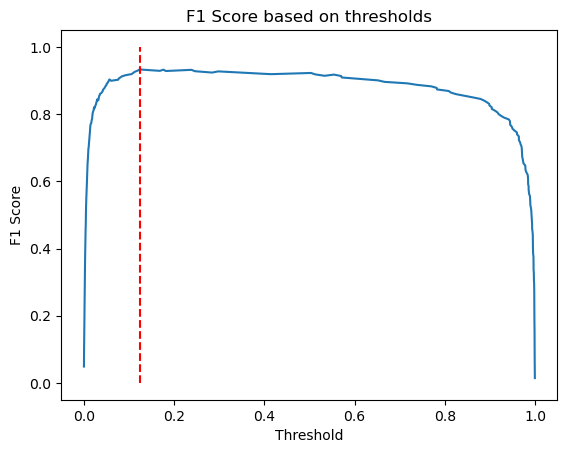

In [21]:
plt.plot(thresholds, (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1]))
plt.vlines(threshold, 0, 1, linestyles='--', color='red', label="Best Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score based on thresholds")
plt.show()

## Predicting active/decoy molecules on ChEMBL dataset using previous model

In [39]:
df = pd.read_csv('cdk2_x.csv', sep=';')
df = df[['Smiles', 'pChEMBL Value']]
df.columns = ['Smiles', 'pChEMBL']
df.dropna(inplace=True)
df['Mol'] = df.Smiles.apply(Chem.MolFromSmiles)
df

,Smiles,pChEMBL,Mol
0,CC(=O)c1c(C)c2cnc(Nc3ccc(N4CCNCC4)cn3)nc2n(C2C...,8.00,<rdkit.Chem.rdchem.Mol object at 0x7f4546ee1da0>
1,CS(=N)(=O)Cc1cccc(Nc2ncc(F)c(-c3ccc(F)cc3OCc3c...,6.11,<rdkit.Chem.rdchem.Mol object at 0x7f4546ee1a30>
2,COc1cc(CS(C)(=O)=NC#N)cc(Nc2ncc(F)c(-c3ccc(F)c...,6.89,<rdkit.Chem.rdchem.Mol object at 0x7f4546ee1a80>
3,C1=C/Cn2ccc3ccc(cc32)-c2ccnc(n2)Nc2ccc(OCCN3CC...,6.64,<rdkit.Chem.rdchem.Mol object at 0x7f4546ee1ee0>
4,O=[N+]([O-])c1ccc(Nc2nccc(-c3cnn4ncccc34)n2)cc1,8.52,<rdkit.Chem.rdchem.Mol object at 0x7f4546ee1990>
...,...,...,...
2757,CC1CN(c2ccc(Nc3ncc4cc5n(c4n3)C3(CCCC3)CNC5=O)n...,4.78,<rdkit.Chem.rdchem.Mol object at 0x7f454ded6d00>
2758,O=C1NCC2(CCCC2)n2c1cc1cnc(Nc3ccc(N4CCNCC4)cn3)...,4.96,<rdkit.Chem.rdchem.Mol object at 0x7f454ded6d50>
2759,CCN1[C@H](C)CN(c2ccc(Nc3ncc4cc5n(c4n3)C3(CCCCC...,5.33,<rdkit.Chem.rdchem.Mol object at 0x7f454ded6da0>
2761,O=C1NCC2(CCCCC2)n2c1cc1cnc(Nc3ccc(C(=O)N4CCN(C...,6.97,<rdkit.Chem.rdchem.Mol object at 0x7f454ded6df0>


In [40]:
df['Mol'] = df['Mol'].apply(standardize)
print(f'{df["Mol"].isna().sum()} molecules could not be standardized')
df.dropna(inplace=True)

5 molecules could not be standardized


In [41]:
df['lip5'] = df['Mol'].apply(lipinski)
print(f'{df["lip5"].sum()} molecules pass Lipinski\'s rule of five')
print(f'{df.shape[0] - df["lip5"].sum()} molecules do not pass Lipinski\'s rule of five')

1668 molecules pass Lipinski's rule of five
232 molecules do not pass Lipinski's rule of five


In [42]:
df['pains'] = df['Mol'].apply(gen_pains)
print(f"{df[df['pains'] > 0].pains.shape[0]} molecules contain PAINS substructures")
print(df.pains.value_counts())
df = df[df['pains'] == 0]

133 molecules contain PAINS substructures
0    1767
1     133
Name: pains, dtype: int64


In [26]:
fp_df = pd.DataFrame((list(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)) for mol in df["Mol"]), columns=[*(f"FP_{x}" for x in range(1,1025))])
fp_df = fp_df.join(df["pChEMBL"])
print(fp_df.shape)

fp_df.replace([np.inf, -np.inf], np.nan, inplace=True)
fp_df.dropna(inplace=True)
print(fp_df.shape)
fp_df

(1767, 1025)
(1115, 1025)


,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,...,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,FP_1024,pChEMBL
0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,8.00
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6.11
2,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,6.89
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.64
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,0,1,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.34
1762,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.17
1763,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.02
1765,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.15


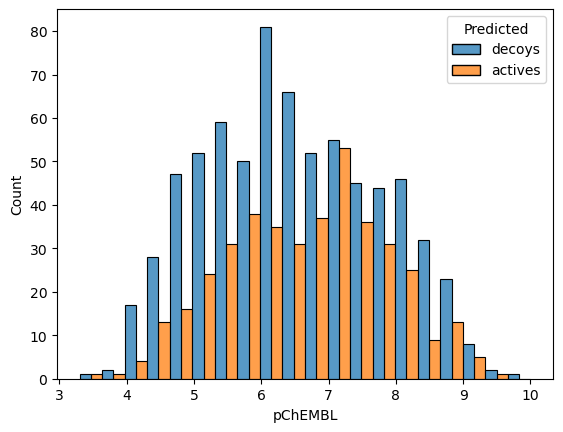

In [27]:
X = fp_df.drop("pChEMBL", axis=1)
y = fp_df["pChEMBL"]

#y_pred_chembl = gbm.predict(X, num_iteration=gbm.best_iteration)
y_pred_chembl = rf.predict(X)

y_pred_chembl = ['actives' if i > threshold else 'decoys' for i in y_pred_chembl]

fp_df['Predicted'] = y_pred_chembl

distributions = pd.DataFrame({'pChEMBL': y, 'Predicted': y_pred_chembl})

distributions['Predicted'].value_counts()

# hist by predicted
sns.histplot(data=distributions, x='pChEMBL', hue='Predicted', bins=20, multiple='dodge')
plt.show()

In [28]:
# do t test for distibutions
from scipy.stats import ttest_ind

actives = distributions[distributions['Predicted'] == 'actives']['pChEMBL']
decoys = distributions[distributions['Predicted'] == 'decoys']['pChEMBL']

ttest_ind(actives, decoys)

Ttest_indResult(statistic=1.8155990746121844, pvalue=0.06970089437194014)

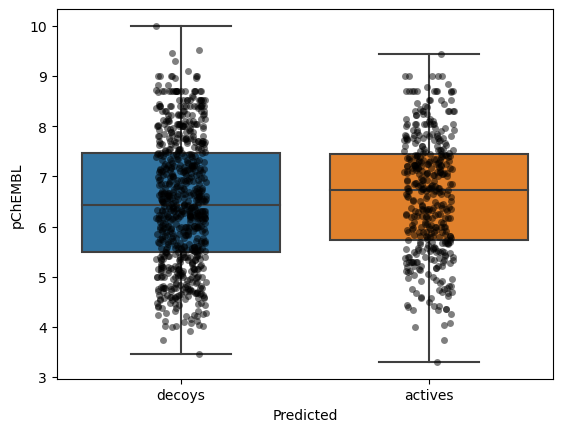

In [29]:
# boxplot by predicted
sns.boxplot(data=distributions, x='Predicted', y='pChEMBL')
sns.stripplot(data=distributions, x='Predicted', y='pChEMBL', color='black', alpha=0.5)
plt.show()

## Visualizing molecules in chemical space

In [30]:
# distance matrix
from scipy.spatial.distance import pdist, squareform

dist = pdist(fp_df.drop(["pChEMBL", 'Predicted'], axis=1), metric='jaccard')
dist = squareform(dist)
dist

array([[0.        , 0.84466019, 0.86238532, ..., 0.51898734, 0.64516129,
        0.62365591],
       [0.84466019, 0.        , 0.47435897, ..., 0.83333333, 0.85849057,
        0.82857143],
       [0.86238532, 0.47435897, 0.        , ..., 0.86407767, 0.875     ,
        0.85714286],
       ...,
       [0.51898734, 0.83333333, 0.86407767, ..., 0.        , 0.39189189,
        0.31944444],
       [0.64516129, 0.85849057, 0.875     , ..., 0.39189189, 0.        ,
        0.45238095],
       [0.62365591, 0.82857143, 0.85714286, ..., 0.31944444, 0.45238095,
        0.        ]])

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  app.launch_new_instance()


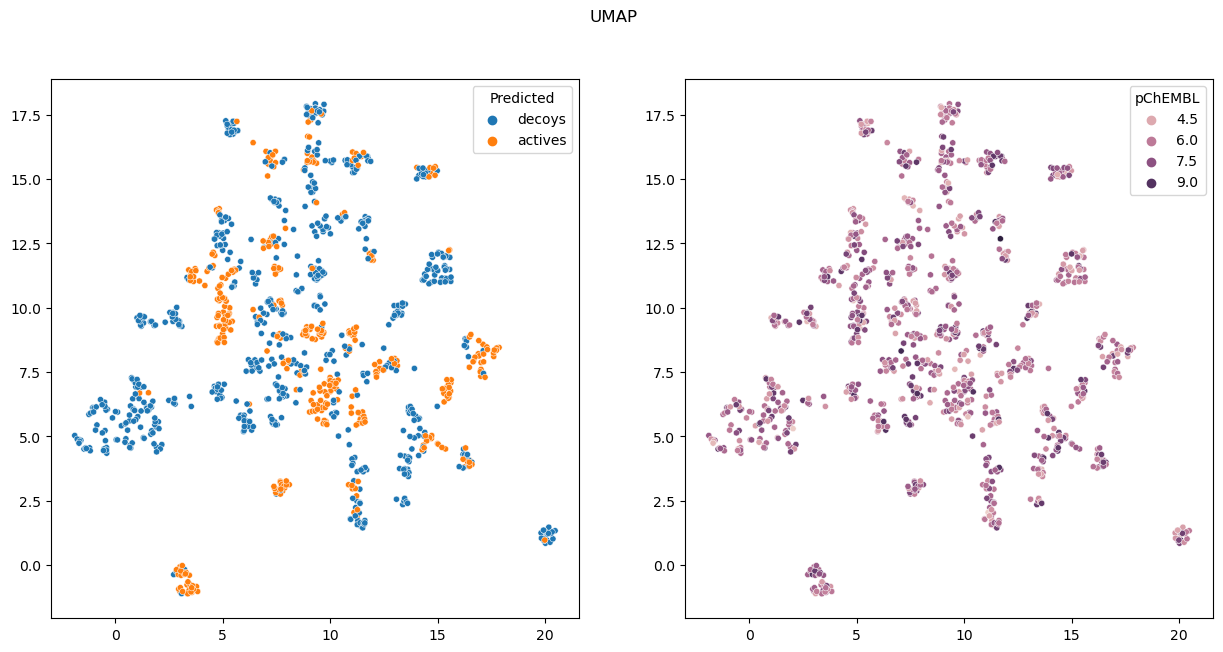

In [31]:
# do umap
import umap

reducer = umap.UMAP(n_neighbors=20, min_dist=0.5, metric='precomputed')
embedding = reducer.fit_transform(dist)

# plot umap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
p1 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['Predicted'],
    ax=ax1,
    alpha=1,
    s=20,
    palette=sns.color_palette("tab10", 10)
)
p2 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['pChEMBL'],
    ax=ax2,
    alpha=1,
    s=20,
)
fig.suptitle('UMAP')
plt.show()

/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,
/home/vmelichar/anaconda3/envs/PNL/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The palett

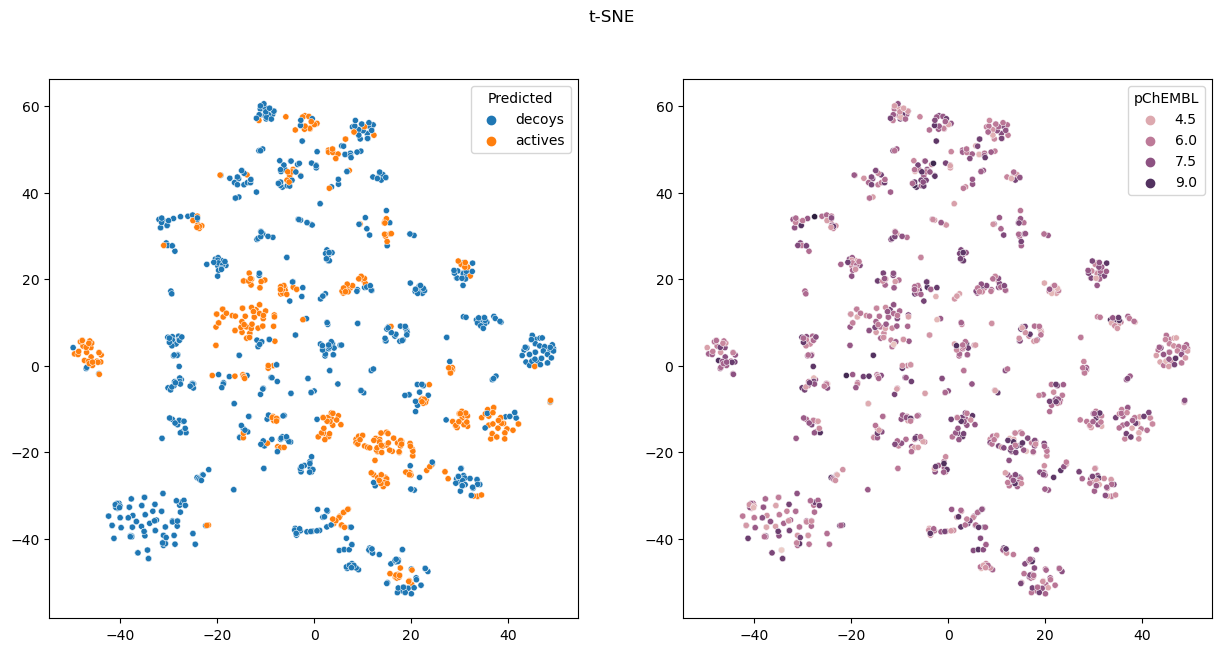

In [32]:
# do tsne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, metric='precomputed')
embedding = tsne.fit_transform(dist)

# plot tsne
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
p1 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['Predicted'],
    ax=ax1,
    alpha=1,
    s=20,
    palette=sns.color_palette("tab10", 10)
)
p2 = sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    legend='brief',
    hue=fp_df['pChEMBL'],
    ax=ax2,
    alpha=1,
    s=20,
)
fig.suptitle('t-SNE')
plt.show()

## Scaffold analysis

In [35]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def scaffold(mol):
    Chem.rdmolops.RemoveStereochemistry(mol) # get rid of stereo, doesn't matter much in scaffolds
    try:
        scaff = MurckoScaffold.MakeScaffoldGeneric(mol) # all atoms->C all bonds-> single
    except ValueError: # if the structure can't be represented by C atoms, just return no scaffold.
        # if such functionality is really desired, then generic graphs can be used instead of C
        return None
    scaff = MurckoScaffold.GetScaffoldForMol(scaff) # remove all sidechains
    return scaff

def get_smiles(mol):
    if not mol:
        return None
    else:
        return Chem.MolToSmiles(mol, canonical=True)

In [ ]:
df['Scaffold'] = df.Mol.apply(scaffold)
df['ScaffoldSmiles'] = df.Scaffold.apply(get_smiles)
df.dropna(inplace=True)

In [44]:
l = len(df.ScaffoldSmiles.unique())
print(f'There are {l} unique scaffolds in the dataset')

There are 394 unique scaffolds in the dataset


In [45]:
len_db = len(df)
counts_db = df.ScaffoldSmiles.value_counts() / len_db
counts_db.index = pd.Series(counts_db.index).replace('', 'C')
counts_db[0:10]

C1CCC(CC2CCCCC2)CC1                                  0.042445
C1CCC(CCC2CCCC3CCCC32)CC1                            0.037351
C1CCC(C2CCC(CC3CCC4CC5CCCC6(CCCCC6)C5C4C3)CC2)CC1    0.036220
C1CCC(CC2CCCC(CC3CCCCC3)C2)CC1                       0.030560
C1CCC(CC2CCCC(C3CCC4CCCCC43)C2)CC1                   0.028862
C1CCC(CC2CCCC(C3CCCCC3)C2)CC1                        0.027165
C1CCC(CCC2CCC3CCCCC32)CC1                            0.019808
C1CCC(C2CCC(CC3CCC4CC5CCCC6(CCCC6)C5C4C3)CC2)CC1     0.018110
C1CCC(CC2CCCC(C3CCCC3)C2)CC1                         0.018110
C1CCC(CC2CC3CCCC3C(CC3CCCCC3)C2)CC1                  0.016412
Name: ScaffoldSmiles, dtype: float64

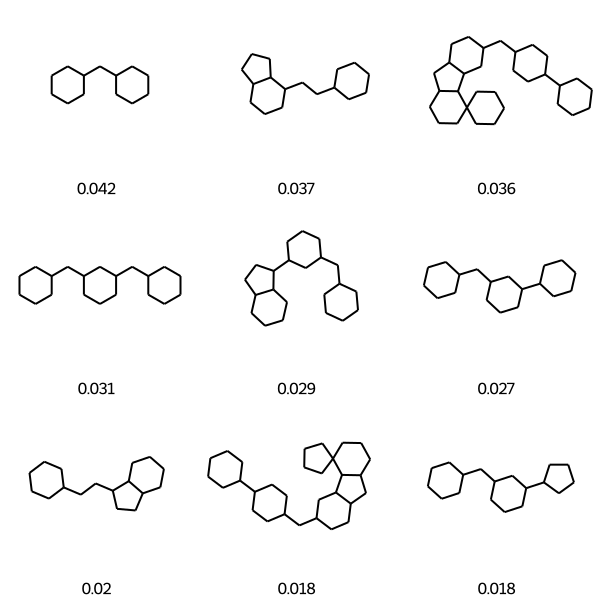

In [52]:
# moltogridimage from rdkit
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# get 10 most common scaffolds
scaffolds = counts_db.index[0:9]
labels = [str(i.round(3)) for i in list(counts_db[0:9].values)]

# get mol objects from smiles
mols = [Chem.MolFromSmiles(s) for s in scaffolds]

# visualize mols
MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200), legends=labels)